<a href="https://colab.research.google.com/github/rahilkadakia/MicroExpressionAI/blob/main/Classification_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
from tensorflow.image import grayscale_to_rgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import sys

base = Path('/content/drive/My Drive/')
sys.path.append(str(base))

# !cp --help

zip_path = base/'Split_Images.zip'
!cp "{zip_path}" .
!unzip -q Split_Images.zip
!rm Split_Images.zip

In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="Split Images/train",target_size=(256,256), shuffle=False)
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="Split Images/val", target_size=(256,256), shuffle=False)

Found 8201 images belonging to 8 classes.
Found 3521 images belonging to 8 classes.


In [ ]:
## Loading model
from tensorflow.keras.applications import MobileNet

base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(256,256,3))
base_model.trainable = False ## Not trainable weights

In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(64, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(8, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])
 
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(from_logits=True)],
)

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
# hist = model.fit(train_images, train_labels, validation_data=(validation_images, validation_labels), batch_size = 32, epochs=50)
# hist = model.fit(train_images, train_labels, epochs=40, steps_per_epoch=len(train_images)//32, validation_steps=len(validation_images)//32, validation_data=(validation_images, validation_labels), batch_size=32, callbacks=[es])

hist = model.fit(
        traindata,
        steps_per_epoch=traindata.samples//32,
        epochs=8,
        validation_data=testdata,
        validation_steps=testdata.samples//32
)

In [ ]:
# model.save('drive/My Drive/MicroExpressions/mobilenet')
model = tf.keras.models.load_model('drive/My Drive/mobilenet')

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
 
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
 
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
 
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
 
plt.plot(hist.history['auc'])
plt.plot(hist.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(testdata)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
testdata

In [ ]:
from sklearn.metrics import classification_report

target_names = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Other', 'Sadness', 'Surprise']
cr = classification_report(testdata.classes, y_pred, target_names=target_names)
print(cr)

              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00      1250
    Contempt       1.00      1.00      1.00       269
     Disgust       0.99      1.00      1.00       200
        Fear       1.00      1.00      1.00       161
   Happiness       1.00      1.00      1.00       582
       Other       1.00      1.00      1.00       622
     Sadness       1.00      1.00      1.00       118
    Surprise       1.00      1.00      1.00       319

    accuracy                           1.00      3521
   macro avg       1.00      1.00      1.00      3521
weighted avg       1.00      1.00      1.00      3521



In [ ]:
type(testdata.samples)

int

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix, jaccard_score
cm = confusion_matrix(testdata.labels, y_pred)
acc = accuracy_score(testdata.labels, y_pred, normalize=True)

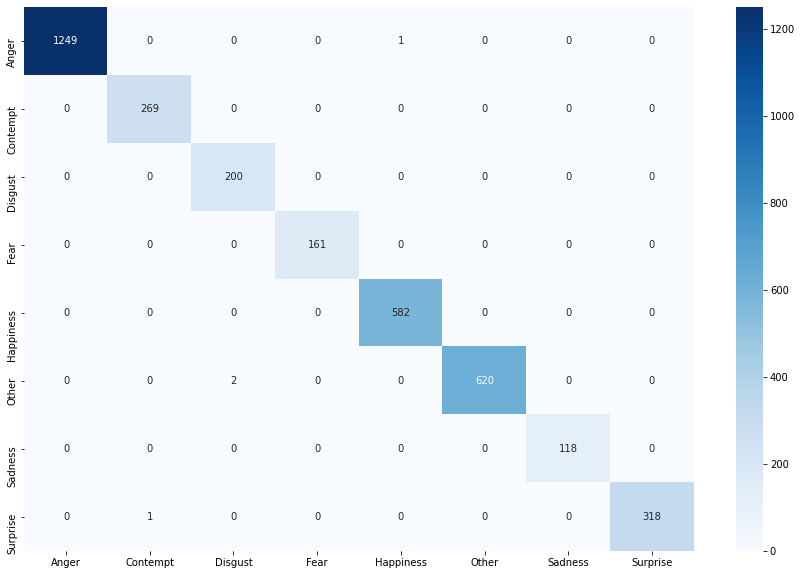

In [ ]:
import seaborn as sns

labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Other', 'Sadness', 'Surprise']

plt.figure(figsize=(15,10))
sns.heatmap(cm, annot = True, cmap=plt.cm.Blues, fmt="d", xticklabels=labels, yticklabels=labels)
plt.show()

In [ ]:
model.evaluate(testdata, batch_size=32)

111/111 [==============================] - 31s 283ms/step - loss: 0.0099 - accuracy: 0.9989 - precision_1: 0.9989 - recall_1: 0.9986 - auc: 1.0000


[0.009938187897205353,
 0.998863935470581,
 0.9988636374473572,
 0.9985799193382263,
 0.9999934434890747]